In [1]:
import level1,level2,analysis,plottools,inversions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import datetime as dt
import scipy.stats as stats
import numpy.ma as ma
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as sciopt

In [3]:
# Data
eddies = np.load('../eddies_last.npy').item()
ADCPs = np.load('../ADCPS.npy').item()

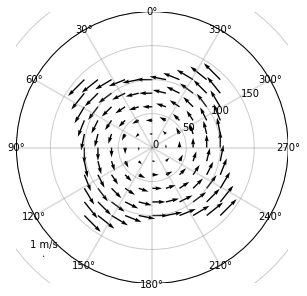

In [3]:
#simulate a whole eddy
xm = np.arange(-100000,101000,20000)
ym = np.arange(-100000,101000,20000)
X,Y = np.meshgrid(xm,ym)
xc = 0
yc = 0
U,V = inversions.Simulate(xc,yc,X,Y,omega=1e-5,fmt='UV')
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
plottools.Hodograph(ax,200,xtext=False,ytext=False,grid=50)
# Set axis limits, in order to see circle aspect MUST be set to equal
#ax.set_xlim(-200,200)
#ax.set_ylim(-200,200)
ax.set_aspect('equal')

Q=plt.quiver(xm/1000,ym/1000,U,V,width=0.005,pivot='tail')
plt.quiverkey(Q,0.1,0.1,0.01,label= '1 m/s')
plt.show()

A filter should be applied directly to the data with 3 dimensions

In [4]:
ADCP = ADCPs['V3']
lon = ADCP['longitudes']
lat = ADCP['latitudes']
depths = ADCP['depths']
V = ADCP['V']
U = ADCP['U']
deltat = 100
m = Basemap(projection='merc',llcrnrlat = min(lat)-1,urcrnrlat = max(lat)+1,llcrnrlon=min(lon)-1,urcrnrlon=max(lon)+1)
x,y = m(lon,lat)
atd = analysis.ComputeATD(lon,lat,m=m)

In [5]:
V_filt = analysis.BoxCarFilter2(V,x,y,depths,40e3,40e3,150)
U_filt = analysis.BoxCarFilter2(U,x,y,depths,40e3,40e3,150)

/home/affholder/Documents/ENS/AFC/Stage/Araujo/Eddie_Tracks/Scripts/ADCP/analysis.py:231: RuntimeWarning: Mean of empty slice
  val = np.nanmean(Mf[indexes])


In [11]:
X = []
Y = []
Z = []
# Vl = []
for i in range(len(x)):
    for j in range(len(depths)):
        X.append(x[i])
        Y.append(y[i])
        Z.append(depths[j])
#         Vl.append(V[i,j])
X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
# Vl = np.array(Vl)
Vlf = V_filt.flatten()

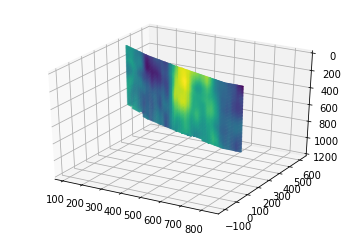

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.set_yticks(np.arange(100,250,10))
# ax.set_xticks(np.arange(100,700,10))
# ax.set_xlim(100,700)
# ax.set_ylim(100,250)
ax.set_zlim(1200,0)
s = ax.scatter(X/1000,Y/1000,Z,c=Vlf,s=0.8)
# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb in zip(Xb, Yb):
    ax.plot([xb/1000], [yb/1000], [0], 'w')

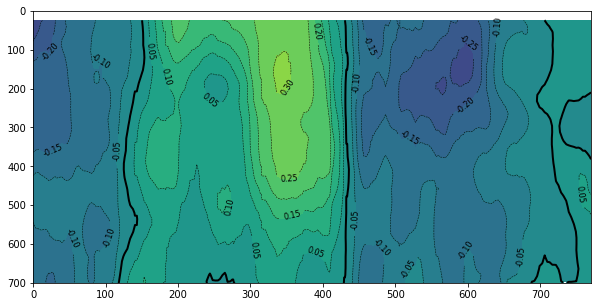

In [13]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(700,0)
plottools.PlotADCP(ax,atd,depths,V_filt)
plt.show()

In [6]:
faisceau,ZZ2,Rvals,Pvals=inversions.SolidBodyCorrelation(U_filt,V_filt,atd,depths,sizemax=200e3)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


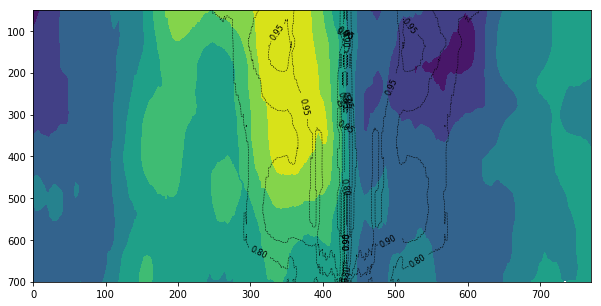

In [6]:
XX,ZZ = np.meshgrid(atd/1000,depths)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(700,50)
ax.contourf(XX,ZZ,np.transpose(V_filt))
# ax.plot(Zeros/1000,depths,'k--',linewidth = 1.5)
levels = [0.8,0.9,0.95]
cont = ax.contour(faisceau/1000,ZZ2,Rvals,linestyles='dashed',colors='k',linewidths=0.5,levels=levels)
ax.clabel(cont, fontsize=8, inline=1, fmt='%1.2f')
# ax.plot(faisceau[np.where(Pvals_sim>0.05)]/1000,ZZ2[np.where(Pvals_sim>0.05)],'k+',ms=2)
plt.show()

In [7]:
indexes = inversions.SBRCindex(Rvals,atd,faisceau,depths,thresh=0.6)

/home/affholder/Documents/ENS/AFC/Stage/Araujo/Eddie_Tracks/Scripts/ADCP/inversions.py:258: RuntimeWarning: invalid value encountered in greater
  faisc = faisceau[i,Rvals[i,:] > thresh]


In [8]:
mask = np.zeros((V_filt.shape[0],V_filt.shape[1]))
mask[indexes] = 1
mask = mask == 1
V_filt_masked = np.ma.array(V_filt,mask=mask)
U_filt_masked = np.ma.array(U_filt,mask=mask)

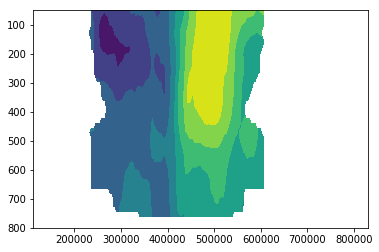

In [9]:
X,Z = np.meshgrid(x,depths)
plt.ylim(800,50)
plt.contourf(X,Z,np.transpose(V_filt_masked))
plt.show()

In [10]:
angles_m = np.angle(U_filt + V_filt*1j)
cos_m = np.cos(angles_m)
sin_m = np.sin(angles_m)
angles_m_msk = np.ma.array(angles_m,mask=mask)
cos_m_msk = np.ma.array(cos_m,mask=mask)
sin_m_msk = np.ma.array(sin_m,mask=mask)

In [11]:
xplore = np.arange(300,500,1)*1e3
yplore = np.arange(150,300,1)*1e3
Merr = inversions.MapError(xplore,yplore,x,y,cos_m[:,15],sin_m[:,15],mask=mask[:,15])

/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


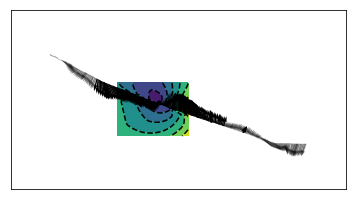

In [23]:
Xp,Yp = np.meshgrid(xplore,yplore)
M = np.transpose(Merr)
# plt.plot(x,y)
plt.contourf(Xp,Yp,M)
cont = plt.contour(Xp,Yp,M,linestyles='dashed',colors='k')
m.plot(Xp[M==np.nanmin(M)],Yp[M==np.nanmin(M)],'k*',ms=5)

m.quiver(x,y,U_filt_masked[:,15],V_filt_masked[:,3],pivot='tail',scale=5)
m.quiver(x,y,U_filt[:,15],V_filt[:,15],pivot='tail',alpha=0.5,scale=5)
plt.show()

In [24]:
Xvc = []
Yvc = []
deltat = 10
for i in range(len(depths)):
    vm = V_filt[:,i]
    if np.sum(np.isnan(vm)) == len(vm):
        xvc = np.nan
        yvc = np.nan
    else :
        vmint = np.nancumsum(vm)*deltat
        vc = np.nanmax(vmint)
        index = np.where(vmint == vc)[0]
        if len(index)>1:
            index = index[0]
        xvc = x[index][0]
        yvc = y[index][0]
    Xvc.append(xvc)
    Yvc.append(yvc)
Xvc = np.array(Xvc)
Yvc = np.array(Yvc)

In [25]:
Xc = []
Yc = []
Er = []
S = []
for i in range(len(depths)):
    msk = ~mask[:,i]
    res = sciopt.minimize(fun = inversions.AngularError,
                          x0=[Xvc[i],Yvc[i]],args=(x[msk],y[msk],cos_m[msk,i],sin_m[msk,i]),
                          method='Powell',tol=1e-8)
    xc = res['x'][0]
    yc = res['x'][1]
    rr = res['fun']
    s = res['success']
    Xc.append(xc)
    Yc.append(yc)
    Er.append(rr)
    S.append(s)
Xc = np.array(Xc)
Yc = np.array(Yc)
Er = np.array(Er)
S = np.array(S)
    

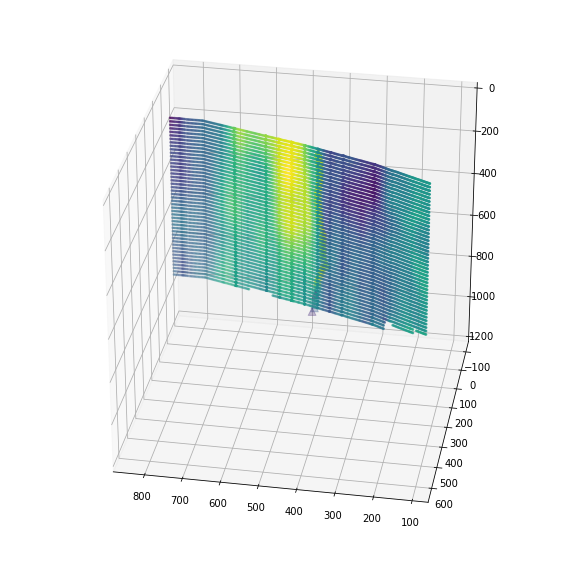

In [29]:
X = []
Y = []
Z = []
# Vl = []
for i in range(len(x)):
    for j in range(len(depths)):
        X.append(x[i])
        Y.append(y[i])
        Z.append(depths[j])
#         Vl.append(V[i,j])
X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
# Vl = np.array(Vl)
Vlf = V_filt.flatten()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# ax.set_yticks(np.arange(100,250,10))
# ax.set_xticks(np.arange(100,700,10))
# ax.set_xlim(100,700)
# ax.set_ylim(100,250)
ax.set_zlim(1200,0)
sc = ax.scatter(X/1000,Y/1000,Z,c=Vlf,s=3)
sc2 = ax.scatter(Xc/1000,Yc/1000,depths,s=60,marker='^',c=Er)
# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb in zip(Xb, Yb):
    ax.plot([xb/1000], [yb/1000], [0], 'w')
ax.view_init(30,100)

/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


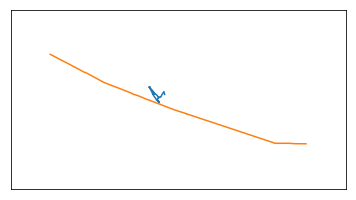

In [27]:
m.plot(Xc,Yc)
m.plot(x,y)

(700, 0)

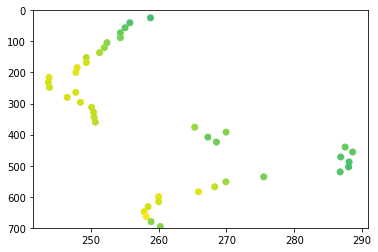

In [74]:
plt.scatter(Yc/1000,depths,c=Er)
plt.ylim(700,0)

In [29]:
## Now project everything on the cylinder

In [209]:
Ur = np.zeros((len(x),len(depths)))
Vr = np.zeros((len(x),len(depths)))
R = np.zeros((len(x),len(depths)))
R2 = np.zeros((len(x),len(depths)))
for i in range(len(depths)):
    xc = Xc[i]
    yc = Yc[i]
    v = V_filt[:,i]
    u = U_filt[:,i]
    r = np.sqrt((x-xc)**2 + (y - yc)**2)
    r2 = np.sign(x-xc)*np.sqrt((x-xc)**2 + (y - yc)**2)
    angles = np.angle((x - xc) + (y - yc)*1j,deg=False)
    num = np.isfinite(u)
    for j in range(len(angles)):
        if num[j]:
            theta = angles[j]
            uri,vri = level2.Rotation([u[j]],[v[j]],theta,[0,0])
        else:
            uri = np.nan
            vri = np.nan
        Ur[j,i] = uri
        Vr[j,i] = vri
    R[:,i] = r
    R2[:,i] = r2

#omegas = 

In [216]:
Zeta  =2*np.angle(R + Vr*1j)

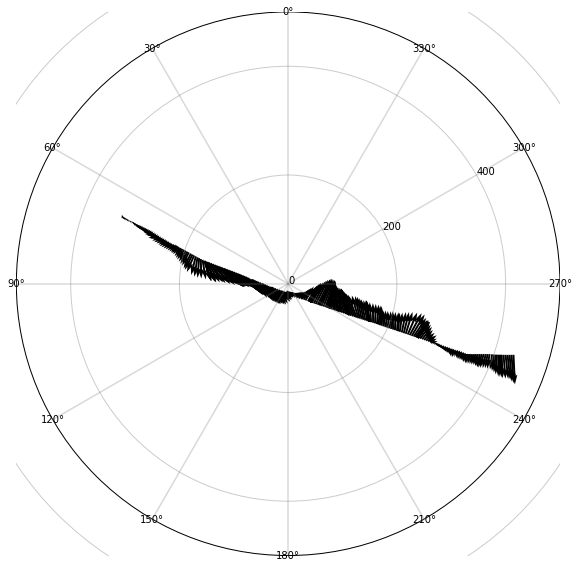

In [122]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
plottools.Hodograph(ax,500,xtext=False,ytext=False,grid=200)
rp = r/1000
ax.quiver(rp*np.cos(angles),rp*np.sin(angles),u,v)
plt.show()

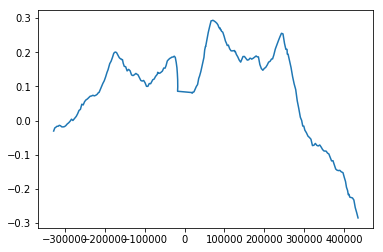

In [212]:
plt.plot(R2[:,0],Vr[:,0])

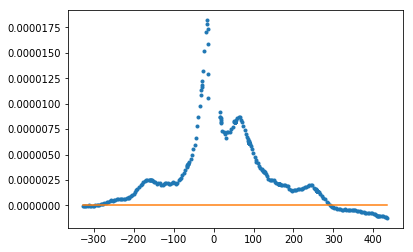

In [215]:
didx = 1
plt.plot(R2[:,didx]/1000,2*np.angle(R[:,didx] + Vr[:,didx]*1j),'.')
plt.plot([R2[0,didx]/1000,R2[-1,didx]/1000],[0,0])

TypeError: Incompatible X, Y inputs to pcolormesh; see help(pcolormesh)

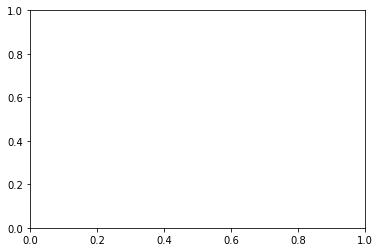

In [232]:
plt.pcolormesh(R2[:,:35],ZZ2[:35,289],np.transpose(Zeta[:,:35]))

In [226]:
np.sum(np.isnan(R2))

9280

In [231]:
R2.shape

(290, 79)